In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\google\auth\crypt\_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


Importer des données

In [2]:

data=pd.read_csv("./laboratory.csv")

In [3]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,14.966,20.688,0.007,4.867,1.522,20.867,910.0,548.505,1876,38.461,...,968.0,24.841,0.014,11.550,44.833,-0.03,8.182,21.999,0.0,16.234
1,14.996,20.687,0.001,3.496,1.521,20.865,915.0,543.500,1887,38.462,...,942.0,24.845,0.002,11.520,44.784,-0.06,8.172,24.962,0.0,14.324
2,15.000,20.687,0.000,5.134,1.521,20.866,916.0,542.134,1858,38.463,...,938.0,24.834,0.000,11.506,44.768,-0.07,8.170,25.293,0.0,15.826
3,14.081,20.688,0.213,4.223,1.521,20.864,918.0,539.314,1856,38.462,...,936.0,24.834,0.618,11.438,44.766,-0.04,8.169,26.403,0.0,12.719
4,14.258,20.687,0.152,8.701,1.522,20.867,915.0,543.551,1862,38.462,...,935.0,24.838,0.543,11.393,44.768,0.00,8.170,25.934,0.0,26.107


In [4]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
51181,2.257,20.906,4.770,227.998,1.530,24.533,798.0,517.499,2046,176.872,...,820.0,28.700,0.958,28.679,39.472,-0.18,8.888,66.425,4.150,710.289
51182,1.920,20.906,4.169,229.625,1.529,24.546,782.0,524.201,2088,177.372,...,844.0,28.721,0.405,28.932,39.171,-0.30,8.826,65.066,3.800,725.006
51183,1.688,20.907,5.038,228.146,1.529,24.572,772.0,516.942,1827,173.799,...,803.0,28.757,0.529,29.264,38.641,-0.56,8.720,62.035,4.670,721.098
51184,1.515,20.905,5.092,246.341,1.530,24.590,761.0,517.797,1828,167.632,...,790.0,28.797,0.394,29.504,38.329,-0.63,8.658,65.898,4.789,780.604
51185,1.225,20.907,4.216,229.139,1.532,24.614,758.0,512.732,1999,162.133,...,822.0,28.815,0.840,29.658,38.106,-0.60,8.619,64.354,4.177,726.724


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [5]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [6]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3','pm1','tvoc','co2','dewpt'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

start_date = '2023-04-19'
end_date = '2023-06-03'
data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
# dates_to_remove = ['2023-04-17', '2023-05-21']
# dates_to_remove = pd.to_datetime(dates_to_remove)
# data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]
print(data)

       oxygen    pm10     co       so2     no2           timestamp      o3  \
18440  20.789   9.315  1.735  2216.850  21.831 2023-04-19 11:39:01  27.653   
18441  20.790   9.040  1.730  2216.820  21.776 2023-04-19 11:41:03  27.600   
18442  20.789  10.338  1.726  2216.730  22.191 2023-04-19 11:43:05  27.512   
18443  20.793   9.173  1.723  2216.770  23.159 2023-04-19 11:45:06  27.481   
18444  20.792   8.218  1.720  2216.800  24.173 2023-04-19 11:47:08  27.371   
...       ...     ...    ...       ...     ...                 ...     ...   
49903  20.925   1.258  1.500   130.865  31.681 2023-06-02 23:51:16  12.203   
49904  20.925   1.608  1.500   130.676  31.438 2023-06-02 23:53:17  12.199   
49905  20.925   1.231  1.500   130.358  31.555 2023-06-02 23:55:18  12.191   
49906  20.924   1.321  1.500   129.813  31.540 2023-06-02 23:57:19  12.224   
49907  20.924   1.341  1.500   129.270  31.233 2023-06-02 23:59:20  12.215   

        sound  pm2_5  temperature  pressure  humidity  
18440  

Modifier le nom de timestamp et le convertir en index

In [7]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen    pm10     co      so2     no2      o3   sound  \
date                                                                          
2023-04-19 11:39:01  20.789   9.315  1.735  2216.85  21.831  27.653  57.259   
2023-04-19 11:41:03  20.790   9.040  1.730  2216.82  21.776  27.600  52.367   
2023-04-19 11:43:05  20.789  10.338  1.726  2216.73  22.191  27.512  52.689   
2023-04-19 11:45:06  20.793   9.173  1.723  2216.77  23.159  27.481  56.539   
2023-04-19 11:47:08  20.792   8.218  1.720  2216.80  24.173  27.371  57.535   

                     pm2_5  temperature  pressure  humidity  
date                                                         
2023-04-19 11:39:01  7.996       19.024   999.613    45.098  
2023-04-19 11:41:03  8.203       19.012   999.632    44.952  
2023-04-19 11:43:05  8.830       19.009   999.608    44.932  
2023-04-19 11:45:06  8.191       19.012   999.611    44.929  
2023-04-19 11:47:08  6.888       19.015   999.604    44.850  


Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

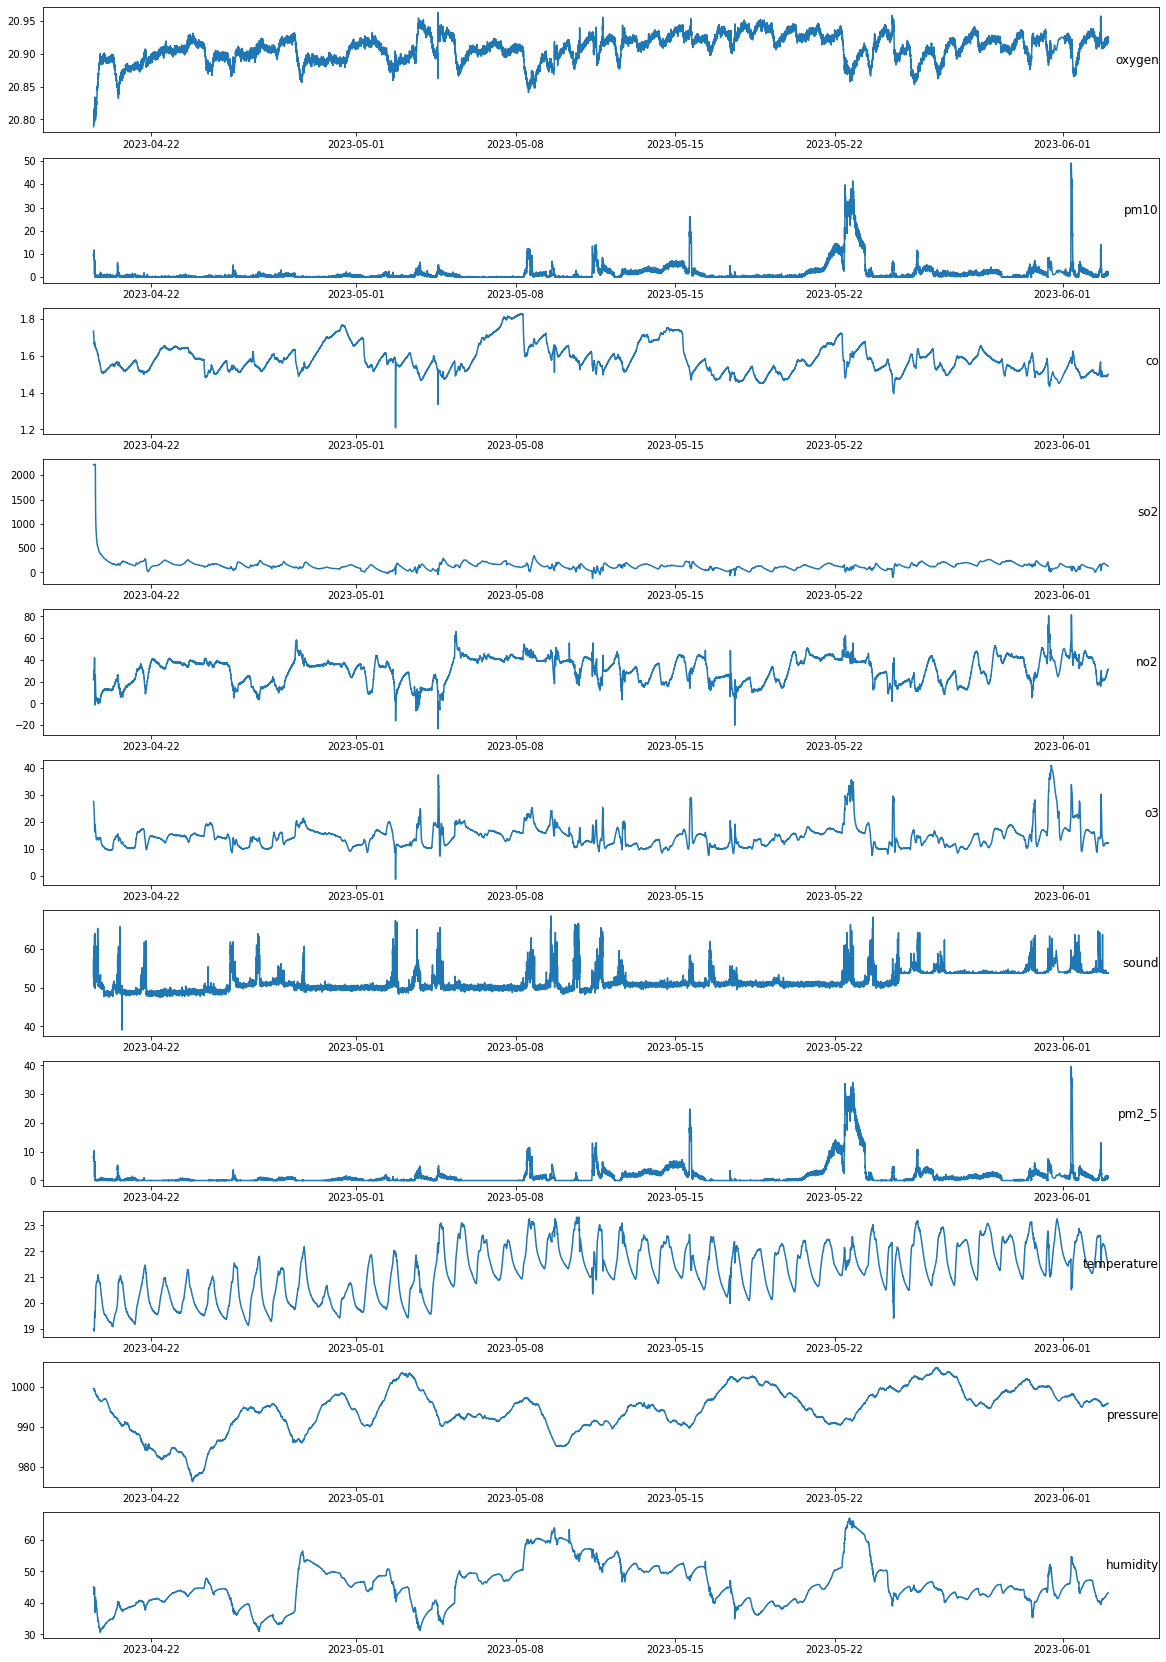

In [8]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**Multivariate LSTM Predictive Modeling**

In [9]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [11]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.000000,0.189904,0.848387,0.996458,0.431124,0.684472,0.619203,0.201654,0.020952,0.816921,0.397319,0.005791,0.184298,0.840322,0.996445,0.430600,0.683219,0.452520,0.206875
2,0.005791,0.184298,0.840322,0.996445,0.430600,0.683219,0.452520,0.206875,0.018219,0.817589,0.393275,0.000000,0.210760,0.833871,0.996406,0.434559,0.681139,0.463491,0.222687
3,0.000000,0.210760,0.833871,0.996406,0.434559,0.681139,0.463491,0.222687,0.017536,0.816746,0.392721,0.023125,0.187009,0.829032,0.996424,0.443796,0.680407,0.594671,0.206572
4,0.023125,0.187009,0.829032,0.996424,0.443796,0.680407,0.594671,0.206572,0.018219,0.816853,0.392637,0.017342,0.167540,0.824193,0.996436,0.453471,0.677807,0.628608,0.173711
5,0.017342,0.167540,0.824193,0.996436,0.453471,0.677807,0.628608,0.173711,0.018902,0.816608,0.390449,0.052032,0.179446,0.817742,0.996360,0.460178,0.675136,0.503492,0.206244


In [12]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-8].values, train.iloc[:, -8:].values
test_X, test_y = test.iloc[:, :-8].values, test.iloc[:, -8:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(28321, 1, 11) (28321, 8) (3146, 1, 11) (3146, 8)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 10 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 13 caractéristiques.

In [13]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(8))
model.compile(loss='mae', optimizer='adam')
print(model.summary())
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()



# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
# model.add(LSTM(50))
# model.add(Dropout(0.5))
# model.add(Dense(11))
# model.compile(loss='mae', optimizer='adam')
# print(model.summary())
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(10))
# model.add(Dropout(0.5))
# model.compile(loss='mae', optimizer=Adam(learning_rate=0.001))
# print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                12400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 408       
Total params: 12,808
Trainable params: 12,808
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/300
394/394 - 1s - loss: 0.0926 - val_loss: 0.0665
Epoch 2/300
394/394 - 1s - loss: 0.0602 - val_loss: 0.0592
Epoch 3/300
394/394 - 1s - loss: 0.0531 - val_loss: 0.0527
Epoch 4/300
394/394 - 1s - loss: 0.0465 - val_loss: 0.0503
Epoch 5/300
394/394 - 1s - loss: 0.0421 - val_loss: 0.0470
Epoch 6/300
394/394 - 1s - loss: 0.0381 - val_loss: 0.0413
Epoch 7/300
394/394 - 1s - loss: 0.0346 - val_loss: 0.0360
Epoch 8/300
394/394 - 1s - loss: 0.0319 - val_loss: 0.0312
Epoch 9/300
394/394 - 1s - loss: 0.0300 - val_loss: 0.0288
Epoch 10/300
394/394 - 1s - loss: 0.0289 - val_loss: 0.0277
Epoch 11/300
394/394 - 1s - loss: 0.0280 - val_loss: 0.0289
Epoch 12/300
394/394 - 1s - loss: 0.0278 - val_loss: 0.0307
Epoch 13/300
394/394 - 1s - loss: 0.0276 - val_loss: 0.0295
Epoch 14/300
394/394 - 1s - loss: 0.0271 - val_loss: 0.0277
Epoch 15/300
394/394 - 1s - loss: 0.0269 - val_loss: 0.0251
Epoch 16/300
394/394 - 1s - loss: 0.0263 - val_loss: 0.0228
Epoch 17/300
394/394 - 1s - loss: 0.0259 - val_lo

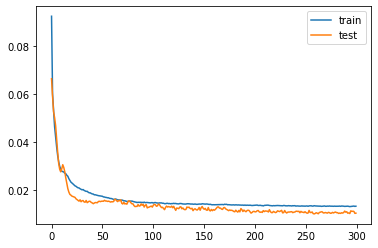

In [14]:
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

In [15]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [8, 9, 10]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
inv_yhat_df = pd.DataFrame(inv_yhat)
print(inv_yhat_df.tail())

test_y = test_y.reshape((len(test_y), train_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

              0         1         2           3          4          5  \
3141  20.926552  1.334688  1.497801  146.565750  31.141291  12.406305   
3142  20.926575  1.365951  1.497957  146.082092  31.287029  12.391449   
3143  20.926657  1.169161  1.496191  145.216354  30.811987  12.299789   
3144  20.926563  1.169149  1.497203  145.393753  31.031021  12.337829   
3145  20.925718  1.148501  1.497200  144.935364  31.025455  12.366429   

              6         7  
3141  54.164642  0.964399  
3142  54.194416  0.993866  
3143  54.213272  0.807418  
3144  54.218994  0.807933  
3145  54.250011  0.785589  
           0      1      2           3          4          5          6      7
0  20.922001  2.275  1.572  200.869034  52.903000  17.575001  53.808998  2.105
1  20.922001  3.239  1.572  200.249985  52.846996  17.580000  53.805000  2.641
2  20.921000  2.367  1.572  199.815002  52.682999  17.569998  53.762001  2.025
3  20.923000  1.961  1.571  199.307007  52.470997  17.585999  53.796001  1.65

In [16]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


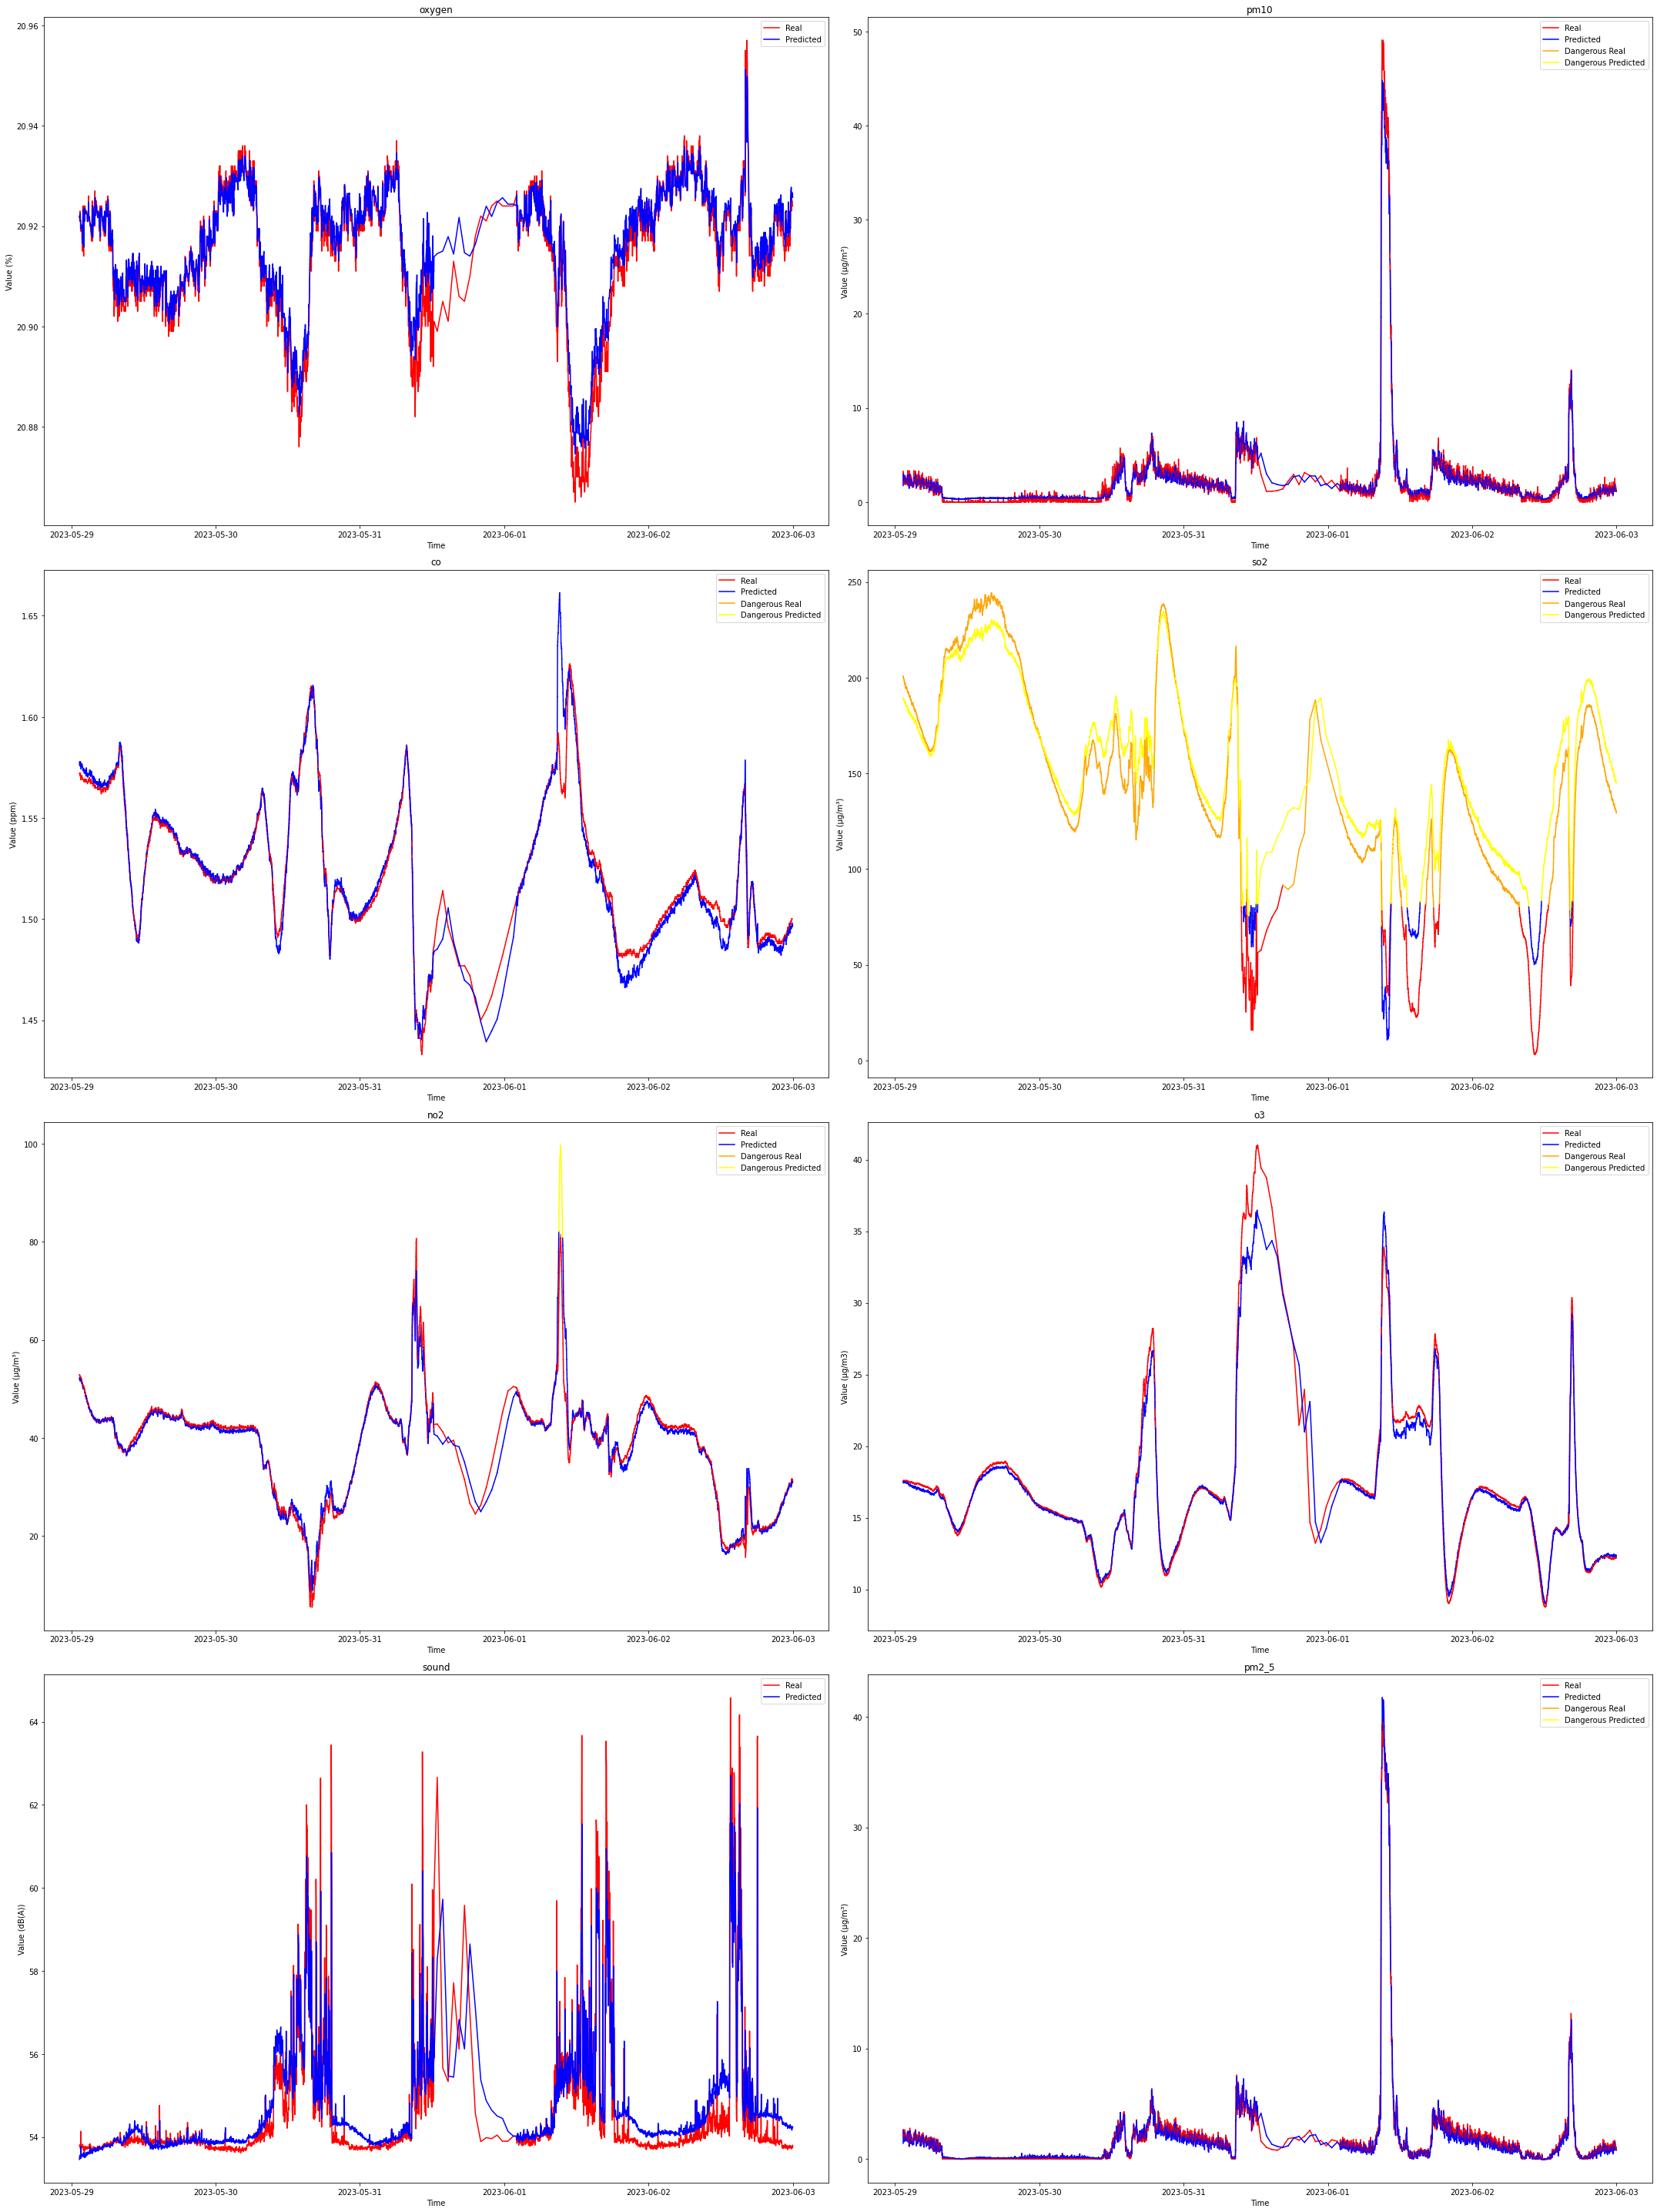

In [17]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 2, figsize=(30, 40))
feature_indices = {
    'oxygen' : 0, 'pm10': 1, 'co': 2, 'so2': 3,
    'no2': 4, 'o3' : 5, 'sound': 6, 'pm2_5': 7
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³',
    'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 2
    col = i % 2

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [18]:

print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [8, 9, 10]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['oxygen', 'pm10', 'co', 'so2', 'no2', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # # Avoid division by zero for MAPE
    # actual_values = inv_y[:, i]
    # predicted_values = inv_yhat[:, i]
    # # Replace zeros in actual values with a small number (1e-10)
    # actual_values = np.where(actual_values == 0, 1e-10, actual_values)
    # mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

(3146, 8) (3146, 8)
Test RMSE for oxygen: 0.004
Test RMSE for pm10: 0.844
Test RMSE for co: 0.008
Test RMSE for so2: 17.900
Test RMSE for no2: 2.344
Test RMSE for o3: 0.815
Test RMSE for sound: 0.756
Test RMSE for pm2_5: 0.599


IAQ

In [19]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [20]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 7]
inv_y_PM25_values = inv_y[:, 7]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [21]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [22]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 3]
inv_y_SO2_values = inv_y[:, 3]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [23]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 4]
inv_y_NO2_values = inv_y[:, 4]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [24]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [25]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 5]
inv_y_O3_values = inv_y[:, 5]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [26]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 8
PM10_SubIndex_col = 9
SO2_SubIndex_col = 10
NO2_SubIndex_col = 11
CO_SubIndex_col = 12
O3_SubIndex_col = 13

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3       col4       col5       col6  \
0  20.921719  1.754971  1.576296  189.301010  51.928032  17.438068  53.458805   
1  20.921835  2.335938  1.577536  189.431976  52.225658  17.493031  53.526531   
2  20.922060  2.968709  1.577704  188.225113  52.375526  17.518198  53.561283   
3  20.921106  2.299310  1.577215  188.666565  52.033581  17.478451  53.509819   
4  20.922503  1.930497  1.575659  188.250092  51.622486  17.446136  53.508873   

       col7      col8      col9       col10      col11      col12      col13  \
0  1.396705  2.327842  1.754971  136.433670  34.496973  90.290518  17.438068   
1  1.942213  3.237021  2.335938  136.477325  34.694693  90.361499  17.493031   
2  2.536551  4.227585  2.968709  136.075038  34.794253  90.371134  17.518198   
3  1.905807  3.176345  2.299310  136.222188  34.567091  90.343151  17.478451   
4  1.561238  2.602063  1.930497  136.083364  34.293992  90.254001  17.446136   

   AQI_calculated  Checks AQI_bu

In [27]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.8029243483788938


In [28]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

2526


anticiper

In [29]:
# 7*2 = 14 min
n_temps = 7
n_features = 11

reframed = series_to_supervised(scaled, n_temps, 1)

In [30]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var10(t-1),var11(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
7,0.000000,0.189904,0.848387,0.996458,0.431124,0.684472,0.619203,0.201654,0.020952,0.816921,...,0.815063,0.385768,0.063583,0.197468,0.801613,0.996262,0.474767,0.665280,0.644111,0.216786
8,0.005791,0.184298,0.840322,0.996445,0.430600,0.683219,0.452520,0.206875,0.018219,0.817589,...,0.814468,0.381502,0.057808,0.198426,0.795161,0.996079,0.475073,0.660529,0.429998,0.235852
9,0.000000,0.210760,0.833871,0.996406,0.434559,0.681139,0.463491,0.222687,0.017536,0.816746,...,0.811691,0.378068,0.098267,0.184787,0.791935,0.996032,0.475311,0.658497,0.629902,0.206345
10,0.023125,0.187009,0.829032,0.996424,0.443796,0.680407,0.594671,0.206572,0.018219,0.816853,...,0.812222,0.377708,0.109833,0.201912,0.787097,0.995976,0.482153,0.655968,0.553239,0.226092
11,0.017342,0.167540,0.824193,0.996436,0.453471,0.677807,0.628608,0.173711,0.018902,0.816608,...,0.810745,0.378372,0.109833,0.194491,0.780645,0.995951,0.490854,0.651643,0.479335,0.222612
12,0.052032,0.179446,0.817742,0.996360,0.460178,0.675136,0.503492,0.206244,0.018219,0.814430,...,0.810394,0.373774,0.104042,0.195022,0.775806,0.995981,0.499776,0.646750,0.568265,0.221527
13,0.052032,0.165583,0.809677,0.996343,0.468756,0.670976,0.625813,0.194366,0.016625,0.815063,...,0.811340,0.369896,0.121391,0.182789,0.772581,0.996028,0.512571,0.641078,0.554329,0.208842
14,0.063583,0.197468,0.801613,0.996262,0.474767,0.665280,0.644111,0.216786,0.013665,0.814468,...,0.811871,0.371060,0.109833,0.195857,0.767742,0.996113,0.514346,0.636776,0.733109,0.224276
15,0.057808,0.198426,0.795161,0.996079,0.475073,0.660529,0.429998,0.235852,0.008654,0.811691,...,0.811203,0.364911,0.121391,0.210842,0.766129,0.996032,0.508239,0.631978,0.604245,0.237163
16,0.098267,0.184787,0.791935,0.996032,0.475311,0.658497,0.629902,0.206345,0.005694,0.812222,...,0.808254,0.359177,0.127174,0.171291,0.761290,0.996023,0.505100,0.627984,0.587720,0.177822


In [31]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 70) (28321, 7) (3140, 70) (3140, 7)


In [32]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(3140, 7, 10) (28321, 7, 10)


In [33]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(8))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

# test3
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
# model.add(LSTM(50))
# model.add(Dropout(0.5))
# model.add(Dense(11))
# model.compile(loss='mae', optimizer='adam')
# print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 408       
Total params: 12,608
Trainable params: 12,608
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Epoch 1/300


ValueError: in user code:

    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\keras\losses.py:1228 mean_absolute_error
        return K.mean(math_ops.abs(y_pred - y_true), axis=-1)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\math_ops.py:1141 binary_op_wrapper
        raise e
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\math_ops.py:527 subtract
        return gen_math_ops.sub(x, y, name)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10466 sub
        "Sub", x=x, y=y, name=name)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\func_graph.py:593 _create_op_internal
        compute_device)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\ops.py:3485 _create_op_internal
        op_def=op_def)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\ops.py:1975 __init__
        control_input_ops, op_def)
    c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 8 and 7 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](sequential_1/dense_1/BiasAdd, IteratorGetNext:1)' with input shapes: [?,8], [?,7].


          0      1      2           3           4          5      6      7   \
0  20.919001  2.035  1.570  445.571014  197.987000  52.342999  1.433  8.938   
1  20.919001  1.995  1.569  444.832001  196.900986  52.308998  1.706  8.936   
2  20.919001  2.609  1.570  444.222992  196.459000  52.328003  2.481  8.949   
3  20.919001  2.462  1.570  443.811005  197.253998  52.031002  2.064  8.961   
4  20.920000  1.877  1.570  444.075989  196.863007  51.806999  1.677  8.963   

           8          9          10     11  
0  933.833984  17.576000  53.719002  1.876  
1  930.737000  17.565998  54.139000  1.980  
2  928.432983  17.568001  53.848000  2.607  
3  929.002991  17.548998  53.737000  2.462  
4  931.614014  17.556997  53.770000  1.787  


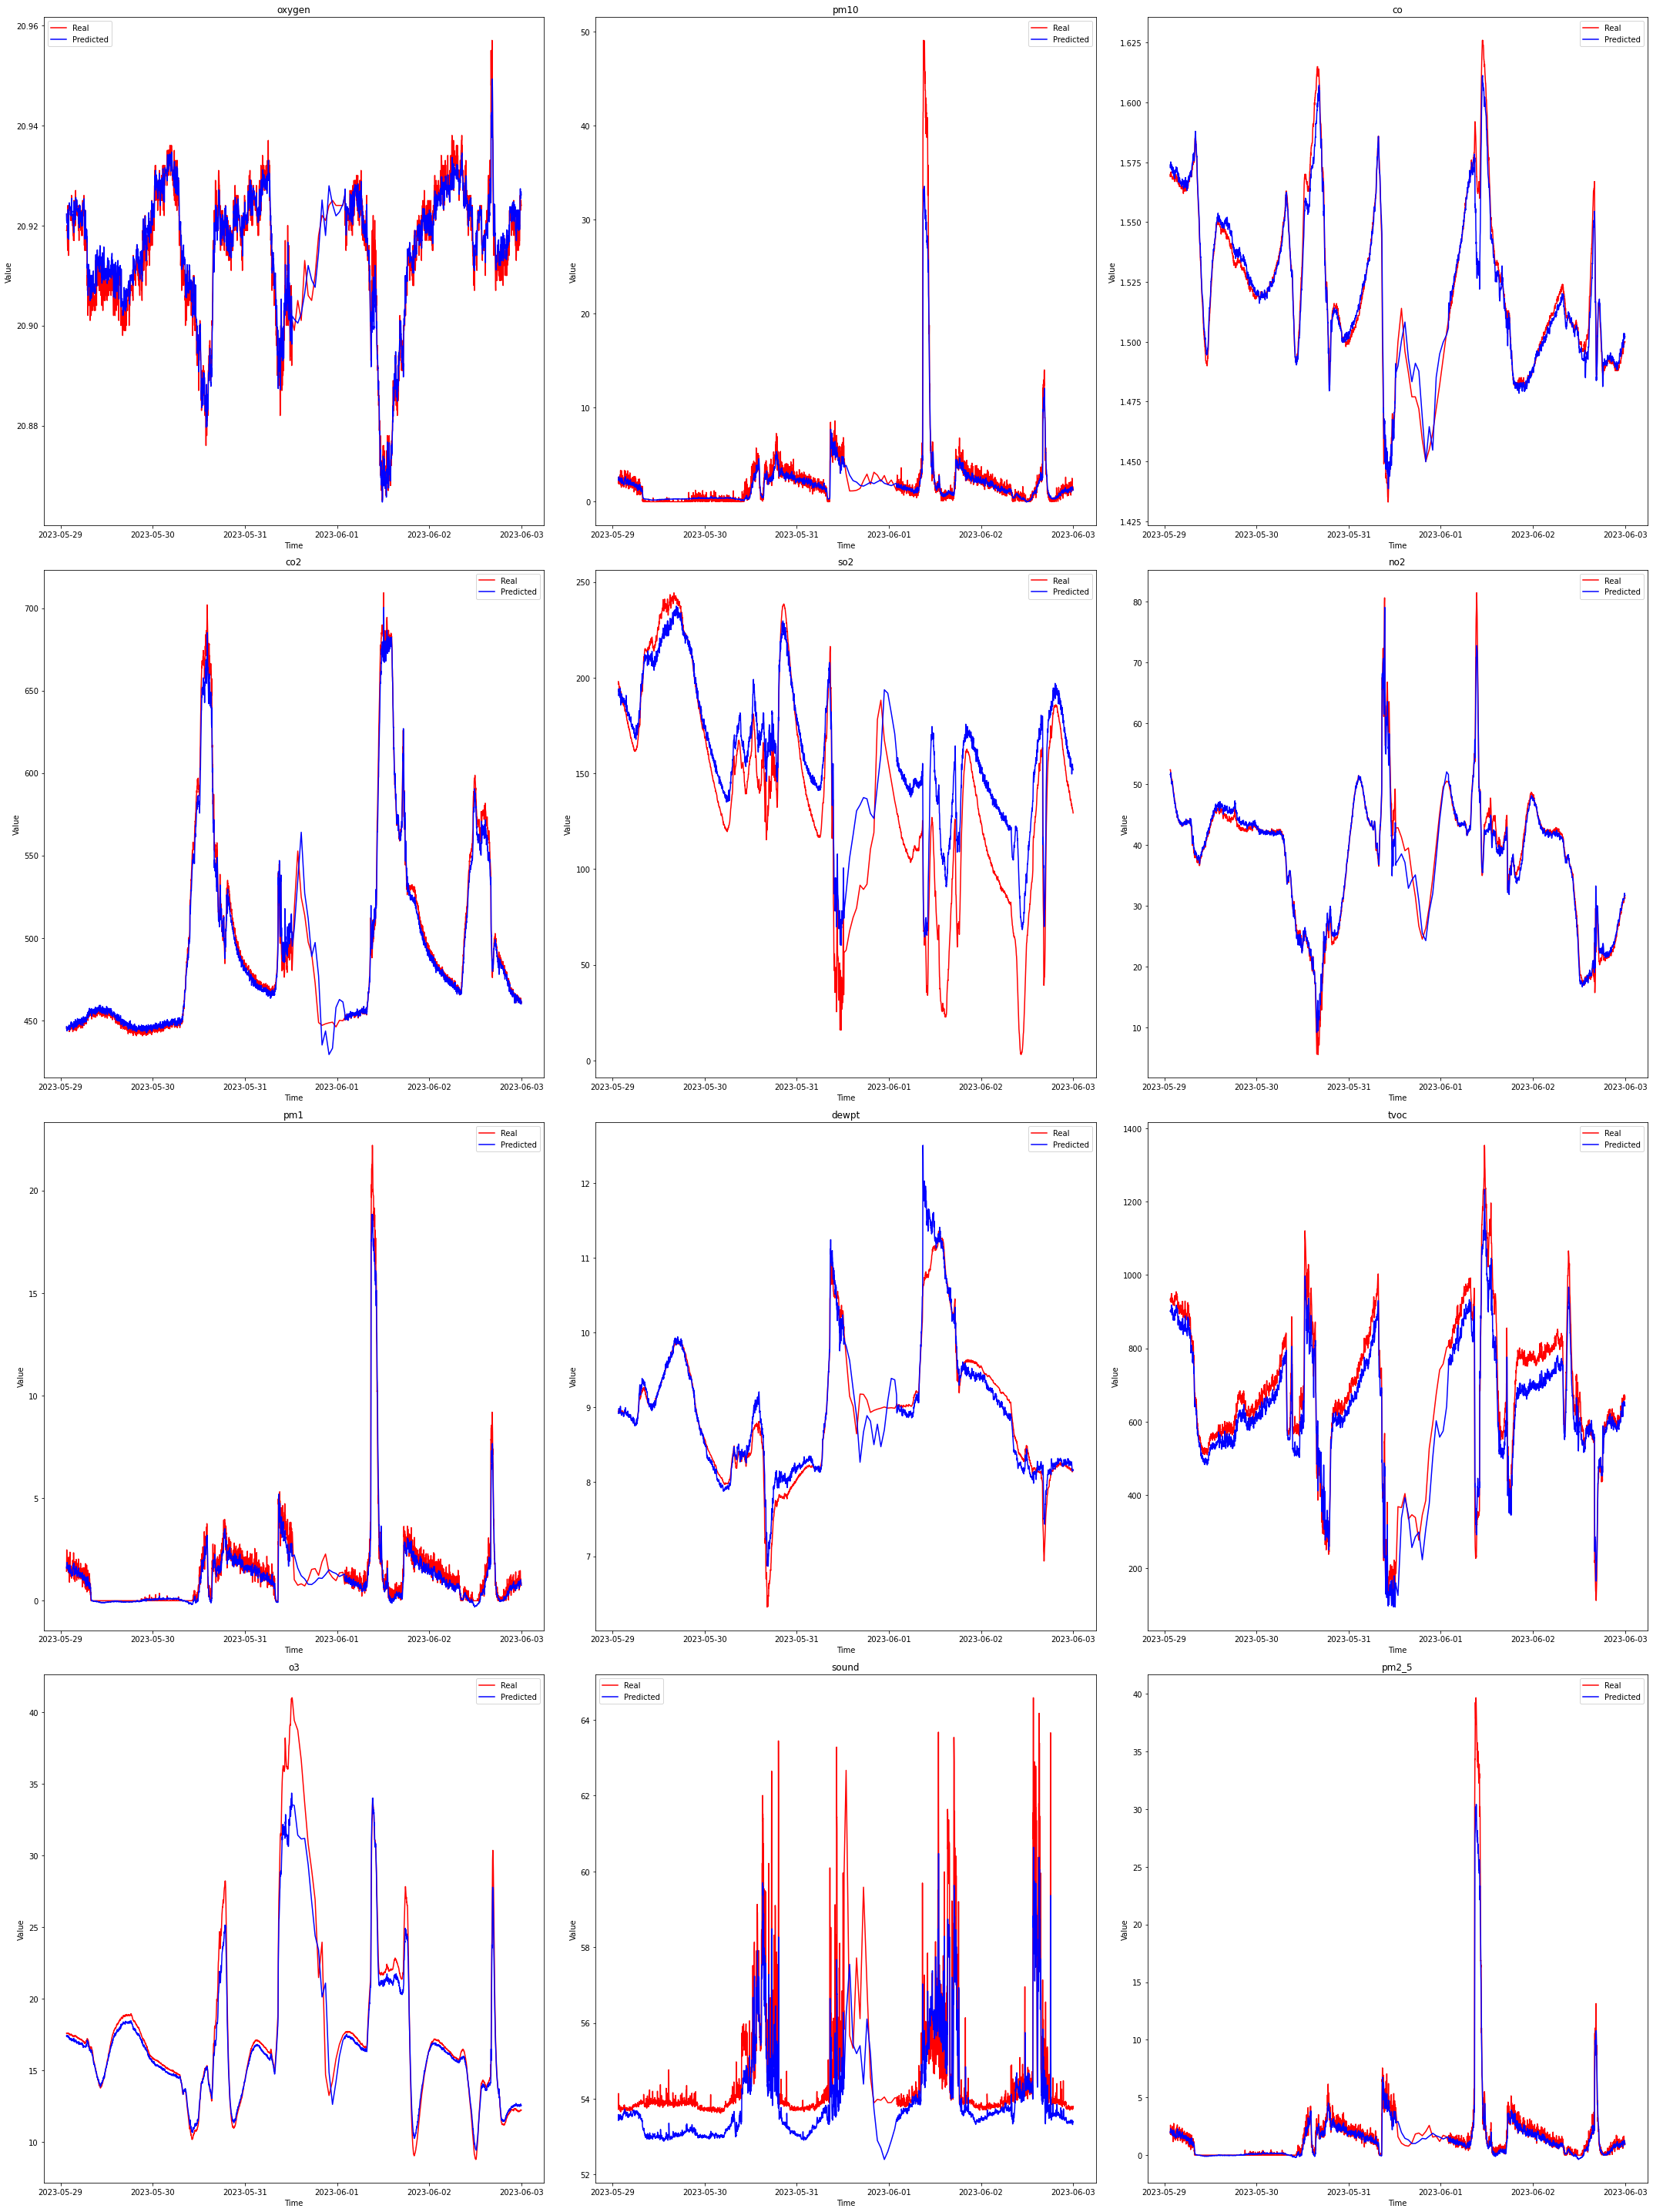

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [8, 9, 10]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

In [ ]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

In [ ]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 2, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'so2': 3,
    'no2': 4, 'o3' : 5, 'sound': 6, 'pm2_5': 7
}
feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³',
    'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 2
    col = i % 2

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [ ]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [8, 9, 10]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

feature_names = ['oxygen', 'pm10', 'co', 'so2', 'no2', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # mape = np.mean(np.abs((inv_y[:, i] - inv_yhat[:, i])/inv_y[:, i]))*100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

(3140, 12) (3140, 12)
Test RMSE for oxygen: 0.003
Test RMSE for pm10: 1.651
Test RMSE for co: 0.006
Test RMSE for co2: 6.300
Test RMSE for so2: 28.374
Test RMSE for no2: 1.368
Test RMSE for pm1: 0.512
Test RMSE for dewpt: 0.212
Test RMSE for tvoc: 58.207
Test RMSE for o3: 1.168
Test RMSE for sound: 1.001
Test RMSE for pm2_5: 1.108


In [ ]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [ ]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 7]
inv_y_PM25_values = inv_y[:, 7]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [ ]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [ ]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 3]
inv_y_SO2_values = inv_y[:, 3]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [ ]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 4]
inv_y_NO2_values = inv_y[:, 4]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [ ]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [ ]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 5]
inv_y_O3_values = inv_y[:, 5]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 8
PM10_SubIndex_col = 9
SO2_SubIndex_col = 10
NO2_SubIndex_col = 11
CO_SubIndex_col = 12
O3_SubIndex_col = 13

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.922293  2.350438  1.573945  446.211853  192.907700  51.533783  1.641013   
1  20.920959  2.252467  1.572680  444.920746  194.055557  51.514359  1.568438   
2  20.920698  2.261407  1.572679  444.724609  192.888062  51.657082  1.566378   
3  20.920534  2.601321  1.574793  444.394928  190.482254  51.896488  1.811480   
4  20.920647  2.654113  1.575200  443.589325  190.905487  51.482170  1.865757   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.917836  901.728760  17.391840  ...  2.016794  3.361323  2.350438   
1  8.916556  901.762268  17.394161  ...  1.923372  3.205620  2.252467   
2  8.913140  899.825867  17.380781  ...  1.926242  3.210403  2.261407   
3  8.960952  901.543091  17.434004  ...  2.246691  3.744485  2.601321   
4  8.980971  901.829407  17.365963  ...  2.302292  3.837153  2.654113   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [ ]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.8197452229299363


In [ ]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

2574
